In [1]:
import os

print(os.environ['LD_PRELOAD'])
import torch

# Save original repr/str
_original_tensor_repr = torch.Tensor.__repr__
_original_tensor_str  = torch.Tensor.__str__
def _tensor_repr_metadata(self):
    return f"Tensor(shape={tuple(self.shape)}, dtype={self.dtype}, device={self.device})"

def print_meta(*args):
    """
    Temporarily override torch.Tensor repr/str to only show metadata,
    print the given dict, then restore the original repr/str.
    """
    # Patch in our metadata-only repr
    torch.Tensor.__repr__ = _tensor_repr_metadata
    torch.Tensor.__str__  = _tensor_repr_metadata

    try:
        # Print the dict (with any tensors inside using the new repr)
        print(*args)
    finally:
        # Restore originals no matter what
        torch.Tensor.__repr__ = _original_tensor_repr
        torch.Tensor.__str__  = _original_tensor_str

# Example usage
if __name__ == "__main__":
    d = {
        "a": torch.zeros(2, 2, dtype=torch.int32),
        "b": torch.randn(1, 3, device="cuda:0")
    }
    print_meta(d)
    print(d)
    # afterwards, torch.Tensor repr is back to normal


/usr/lib/x86_64-linux-gnu/libcuda.so:/usr/lib/x86_64-linux-gnu/libnvidia-ml.so.1
{'a': Tensor(shape=(2, 2), dtype=torch.int32, device=cpu), 'b': Tensor(shape=(1, 3), dtype=torch.float32, device=cuda:0)}
{'a': tensor([[0, 0],
        [0, 0]], dtype=torch.int32), 'b': tensor([[-0.1362,  0.1685,  0.1478]], device='cuda:0')}


I0705 23:08:35.745451  613068 google_auth_provider.cc:149] Using credentials at /home/ubuntu/.config/gcloud/application_default_credentials.json
I0705 23:08:35.745619  613068 google_auth_provider.cc:156] Using OAuth2 AuthProvider
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


6


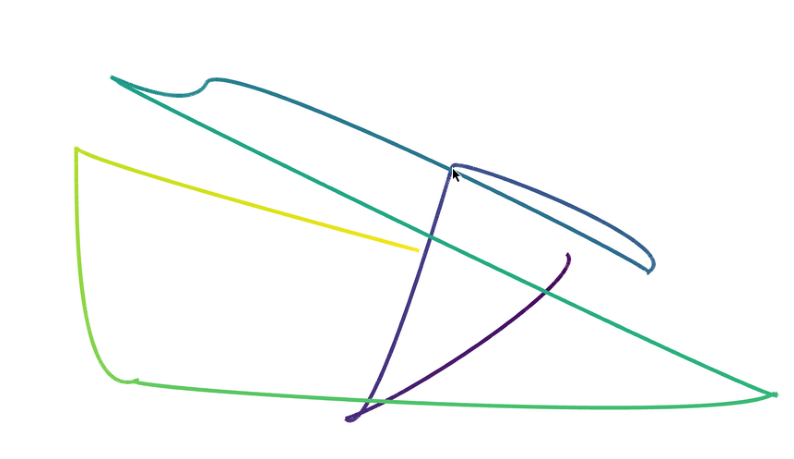

{'input_ids': Tensor(shape=(1, 2048), dtype=torch.int64, device=cuda:0), 'attention_mask': Tensor(shape=(1, 2048), dtype=torch.int64, device=cuda:0), 'pixel_values_videos': Tensor(shape=(6120, 1176), dtype=torch.float32, device=cuda:0), 'video_grid_thw': Tensor(shape=(1, 3), dtype=torch.int64, device=cuda:0), 'video_second_per_grid': Tensor(shape=(1,), dtype=torch.float32, device=cuda:0), 'action_tokens': Tensor(shape=(1, 2048), dtype=torch.bool, device=cuda:0)}


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Qwen2_5OmniThinkerForActionModelling were not initialized from the model checkpoint at Qwen/Qwen2.5-Omni-3B and are newly initialized: ['action_head.0.bias', 'action_head.0.weight', 'action_head.2.bias', 'action_head.2.weight', 'action_token_embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'config': Qwen2_5OmniTextConfig {
  "attention_dropout": 0.0,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "init_std": 0.02,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
 

In [2]:


import torch
from transformers import AutoTokenizer

from modeling.data.video_action import ActionDataSample, fetch_data, make_raw_prompt
from modeling.modules.action_instruct.qwen_25o_actions import (
    Qwen2_5OmniThinkerForActionModelling,
)

# default: Load the model on the available device(s)

PREAMBLE = "<|im_start|>system\nYou are Qwen, a helpful video processing assistant. Where is the cursor at the end of the video.<|im_end|>\n"

data, frames = await fetch_data(
    num_actions=3,
    path="gs://induction-labs/jonathan/synth/cursor_follow_v1/sample_3.zarr",
    seq_length=2048,
    start=0,
    raw_prompt=make_raw_prompt(prefix=PREAMBLE),
)
from synapse.video_loader.render_frame import render_zarr_frame

print(len(frames))
render_zarr_frame(frames[-1])
data = ActionDataSample.combine_batch([data])
inputs = data.qwen_inputs.model_dump() 
inputs['action_tokens'] = data.action_tokens

for k, v in inputs.items():
    if isinstance(v, torch.Tensor):
        inputs[k] = v.to("cuda")
print_meta(inputs)

# config = Qwen2_5OmniThinkerConfig.from_pretrained("Qwen/Qwen2.5-Omni-7B")
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype=torch.bfloat16, device_map="auto"
# )
# model = Qwen2_5OmniThinkerForConditionalGeneration.from_pretrained(
#         "Qwen/Qwen2.5-Omni-7B", torch_dtype=torch.bfloat16, device_map="auto"
#     )
model = Qwen2_5OmniThinkerForActionModelling.from_pretrained(
        "Qwen/Qwen2.5-Omni-3B", torch_dtype=torch.bfloat16, device_map="auto"
    )

# t = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
t = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Omni-3B")
# inputs.pop("video_second_per_grid")
with torch.no_grad():
    result = model.forward(
        # cursor_path=data.cursor_path,
        # action_tokens=data.action_tokens.to("cuda"),
        **inputs,
    )
    result2 = model.generate(**inputs,  max_new_tokens=50)

print_meta(result, result2)
print("###########")
print_meta(t.decode(result2[0], skip_special_tokens=False))
print("###########")
print(t.decode(inputs['input_ids'][0], skip_special_tokens=False))




6


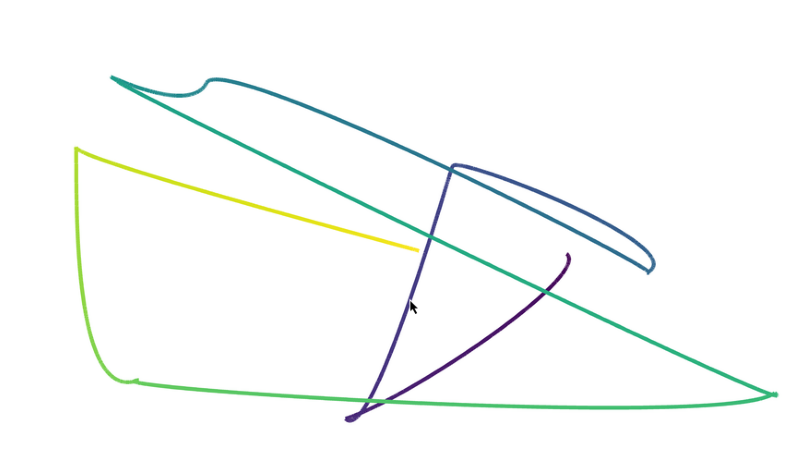

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [4]:
from synapse.video_loader.render_frame import render_zarr_frame

print(len(frames))
render_zarr_frame(frames[-2])



In [3]:
from transformers.models.qwen2_5_vl import Qwen2_5_VLProcessor

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2-VL/space_woaudio.mp4",
            },
            {"type": "text", "text": "Describe this video."},
        ],
    }
]

processor = Qwen2_5_VLProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
text
# image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|video_pad|><|vision_end|>Describe this video.<|im_end|>\n<|im_start|>assistant\n'